# Importar librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
from pyproj import Proj
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from netCDF4 import Dataset, num2date
from pytz import timezone
import pytz
import missingno as msno
import re 
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)


import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# Funciones
def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    -----------------------------------------------------------
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    ----------------------------------------------------------
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

def min_ind_rotated_grid (value1, vector1, value2, vector2, delta, view_coords:bool = None):
    """Función para encontrar la mínima diferencia entre dos celdas, usando una grilla de coordenadas 
    X y Y
    ---------------------------------------------------------------------
    Input: 
    - Value1: valor a encontrar de la coordenada x
    - Vector1: vectores donde quiere encontrar dicho valor en la malla X 
    - Value2: valor a encontrar de la coordenada y
    - Vector2: vectores donde quiere encontrar dicho valor en la malla Y 
    - delta: radio para encontrar ese valor 
    - view_coords: Boleano para imprimr las cordenadas reales y en la malla
    ----------------------------------------------------------------------
    Output: 
    - Indi: Indice correpondiente a la fila 
    - Indj: Indice correspondiente a la columna
    """
    indices = np.where(((vector1 > value1-(delta)) & (vector1 < value1+(delta))) & 
                        ((vector2 > value2-(delta)) & (vector2 < value2+(delta))))

    for i, j in zip(indices[0], indices[1]): 
        try :
            if( vector1[i, j] - value1 < vector1[i+1, j+1] - value1) & (vector2[i, j] - value2 < vector2[i+1, j+1] - value2):
                indi = i
                indj = j
            else:
                indi = i+1
                indj = j+1
        except:
            print('************error**********************')
    if view_coords == True:
        print(f'Indices: {indi}, {indj}')
        print(f'Valor 1: {vector1[indi, indj]}, Valor real 1: {value1}' )
        print(f'Valor 2: {vector2[indi, indj]}, Valor real 2: {value2}' )
    return indi, indj

# Funciones

In [3]:
def read_grid_file_d3d(num_btw_lines:int, ncols:int, nrows:int, path:str, name_file_grid:str, name_file_deep:str):
    """
    This function read the data from .grd file obtened of d3d
    --------------------------------------------------------------------
    Input:
    - num_btw_lines: cantidad de lineas entre cada eta
    - nrows: numéro de filas del archivo
    - ncols: numéro de columnas del archivo
    - path: ruta del archivo
    - name_file_grid:nombre del archivo
    --------------------------------------------------------------------
    Output: 
    - dic_ : diccionario donde cada llave es una fila y contine 
    las respectivas coordendas que deben ser iguales al numero de columnas 
    """
    patron_eta = r'\b\w+=\s*\d+'
    patron_num =  r'\d+\.\d+E[+-]?\d+'

    with open(f'{path}/{name_file_grid}', 'r') as f:
        contenido = f.read ()
    keys_dic = re.findall(patron_eta, contenido)

    with open(f'{path}/{name_file_grid}', 'r') as f:
        lineas = f.readlines()

    dic_ = {}
    for j, key in enumerate (keys_dic):
        list_ = []
        for i, linea in enumerate(lineas):
            eta = re.findall(patron_eta, linea)
            try:
                if  key == eta[0]:
                    nums_linea = re.findall(patron_num, linea)
                    for nu in nums_linea:
                        list_.append(float(nu))
                    for k in range (1, num_btw_lines):
                        nums_linea_plus = re.findall(patron_num, lineas[i+k])
                        for num in nums_linea_plus:
                            list_.append(float(num))             
            except: 
                pass
        arr= np.array(list_).reshape((ncols-1, 2), order = 'F') 
        dic_.update({key:pd.DataFrame({'X': arr[:,0], 'Y': arr[:,1]})})
    
    patron_num =  r'[-+]?\d+\.\d+E[+-]?\d+'
    with open(f'{path}/{name_file_deep}', 'r') as f:
        contenido = f.read ()
    deep = re.findall(patron_num, contenido)
    Z = []
    for z in deep:
        Z.append(float(z))
    Z = np.array(Z).reshape((nrows, ncols))
    Z[Z<0] = np.nan
    # Z = Z[:-1, :-1]


    X = np.zeros(shape = (nrows-1, ncols-1))
    Y = np.zeros(shape = (nrows-1, ncols-1))
    for i, key in enumerate(list(dic_.keys())):
        X[i, :] = dic_[key]['X']
        Y[i, :] = dic_[key]['Y']

    return X,Y, Z

In [4]:
def read_coast_line (path:str, name_file:str):
    """
    Esta función lee los datos de la linea de costa de un archivo .mat (v6)
    -------------------------------------------------------------------------
    Input:
    - path: ruta del archivo
    - name_file: nombre del archivo
    -------------------------------------------------------------------------
    Output:
    - Data Frame de la linea dosta
    """
    data_dir = pjoin(dirname(sio.__file__), path) # Definir Ruta
    mat_fname = pjoin(data_dir, name_file)     # Econtrar el archivo
    data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
    xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
    lc  = np.column_stack((xlc,ylc))
    df_lc = pd.DataFrame({'X':lc[:,0], 'Y':lc[:,1] })
    return df_lc

In [5]:
def bat_figure(df_lc:pd.DataFrame, X:np.array, Y:np.array, Z:np.array,delta_lim:float ,delta:float, active_puntos_obs: bool,size:tuple = (7, 5.5), df_ind = None, bottom_legend = None):
    """Función para graficar la malla orientada
    -------------------------------------------------------------------------------------------------
    Input: 
    - df_lc: linea de costa
    - X: arreglo en dos o una dimensión de la malla (dirección x)
    - Y: arreglo en dos o una dimensión de la malla (dirección y)
    - Z: arreglo de las profundidades, las dimesiones deben corresponder con las dimensiones de X y Y
    - size: tupla de las dimensiones de la figura
    - delta: delta para ubicar el norte respecto a la esquina superior derecha (se resta)
    - delta_lim: limites de la figura
    -------------------------------------------------------------------------------------------------
    Output:
    - Figure 

    """

    fig, ax = plt.subplots(figsize = size)
    colormap = cm.Blues
    levels = list(np.round(np.nanmax(Z)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 100])/100,0))
    pc = ax.contourf(X, Y, Z,levels = levels,cmap=colormap)
    cb=plt.colorbar(pc)
    a = ax.contour(X, Y, Z,colors="gray",levels=levels,\
                    linewidths=0.2)
    labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
    ax.set_xlabel ('E [m]',size=13, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=13, fontweight = 'semibold')
    if (X.min() < df_lc['X'].min()) | (Y.min() < df_lc['Y'].min()):
            ax.set_xlim([X.min() - delta_lim, X.max() + delta_lim])
            ax.set_ylim([Y.min()- delta_lim, Y.max() + delta_lim])
    else:
        ax.set_xlim([df_lc['X'].min(), X.max() + delta_lim])
        ax.set_ylim([df_lc['Y'].min(), Y.max() - delta_lim])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cb.set_label('Depth [m]',size=13, fontweight = 'semibold')
    cb.set_ticklabels(cb.get_ticks(),size=10)
    fig_params(ax)
    fig.suptitle("Bathymetry", size = 13, fontweight = 'semibold')     # Titulo de la figura
    ax.set_title('San Andrés Island',size = 13, fontweight = 'semibold')   # Subtítulo de la figura
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)

    brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)


    fig.tight_layout()
    plt.xticks(rotation = 20)
    plt.grid(False)

In [6]:
def obs_DataFrame (dic_points_plus:dict ):
    """
    Esta función crea un data frame con los puntos de observación 
    ----------------------------------------------------------------------------------
    Input:
    - lis_puntos_plus: lista de puntos adicionales que se requiera ingresar, ej: ['Barrera', ind_col, ind_row]
    -----------------------------------------------------------------------------------
    Output:
    - df_ind: data frame con todos los putnos de observación asignados
    """
    df_perfiles = pd.read_csv('Coordenas_Perfiles.csv', usecols =[1,2,3,4,5,6])
    names_pst= []
    ind_col_pst = []
    ind_row_pst = []

    k = 0
    for i, j in zip (df_perfiles['x_field'], df_perfiles['y_field']):
        try:
            ind_ts = min_ind_rotated_grid (value1 = i , vector1 = X, value2 = j, vector2 = Y, delta = 100, view_coords = False)
            names_pst.append(df_perfiles['Names'][k])
            ind_col_pst.append(ind_ts[1])
            ind_row_pst.append(ind_ts[0])
        except: 
            pass
        k = k +1

    df_pts = pd.DataFrame({'ID':names_pst, 'Ind_X':ind_col_pst, 'Ind_Y':ind_row_pst})
    df_pts.drop_duplicates(subset=['Ind_X', 'Ind_Y'], inplace = True)
    df_pts.reset_index(drop=True, inplace=True)
    
    df_ind = pd.concat([pd.DataFrame(dic_points_plus), df_pts], ignore_index=True)
    df_ind['Ind_X'] = df_ind['Ind_X'].astype('int') 
    df_ind['Ind_Y'] = df_ind['Ind_Y'].astype('int')
    return df_ind

def save_obs_file (path:str, df_ind:pd.DataFrame):
    """
    Esta función guarda los puntos de observación 
    ----------------------------------------------------------------------------------
    Input:
    - path: ruta donde se guardará el archivo
    - df_ind: Data frame con las confuguración requerida para generar el archivo
    """
     # Guardar archivo con puntos de observación
    f =open(path+'\PUNTOS_OBS_SAL_TEMP.obs','w')
    for i in range (len(df_ind.ID)):
        a = f'{df_ind.iloc[i].ID:<17}'
        b = f'{df_ind.iloc[i].Ind_X :>8}'
        c = f'{df_ind.iloc[i].Ind_Y :>6}'
        print(a+' '+b+' '+c)
        f.write(a+' '+b+' '+c+'\n')
    f.close()

In [7]:
def df_project_grid_grid(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X':X[:,0], 'Y':Y[:,0]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}),
                    pd.DataFrame({'X':X[:,n_cols-2], 'Y':Y[:,n_cols-2]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[0,:], 'Y':Y[0,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[n_rows-2,:], 'Y':Y[n_rows-2,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]})]).reset_index(drop=True)
    
    fun_coords = lambda x: coord_wgs(df_bat.iloc[x,0], df_bat.iloc[x,1])
    coords_bat = list(map(fun_coords, df_bat.index))
    df_bat['lon'] = list(map(lambda x: coords_bat[x][0], df_bat.index))
    df_bat['lat'] = list(map(lambda x: coords_bat[x][1], df_bat.index))

    return df_bat

# Lectura de datos

In [8]:
# path = r'C:\Users\paula\Desktop\BAT_SAI_GRID_2_NORTE'
# name_file_samples = 'BAT_SAI_NORTE.xyz'
# df_samples = pd.read_csv(f'{path}\{name_file_samples}', sep= '\s+', names=['X', 'Y', 'Z'])

In [9]:
# def group_depth(z):
#     if z >= 1000:
#         z =  400
#     if (z >= 800) & (z < 1000):
#         z = 390
#     if (z >= 600) & (z < 800):
#         z = 380
#     if (z >= 400) & (z < 600):
#         z = 370
#     return z

# df_samples ['Z'] = df_samples['Z'].apply(group_depth)

In [10]:
# name_file = 'Bat_SAI_NORTE_RE.xyz'
# np.savetxt(path+'/'+name_file, df_samples.values, delimiter=' ', fmt = "%1.7f")

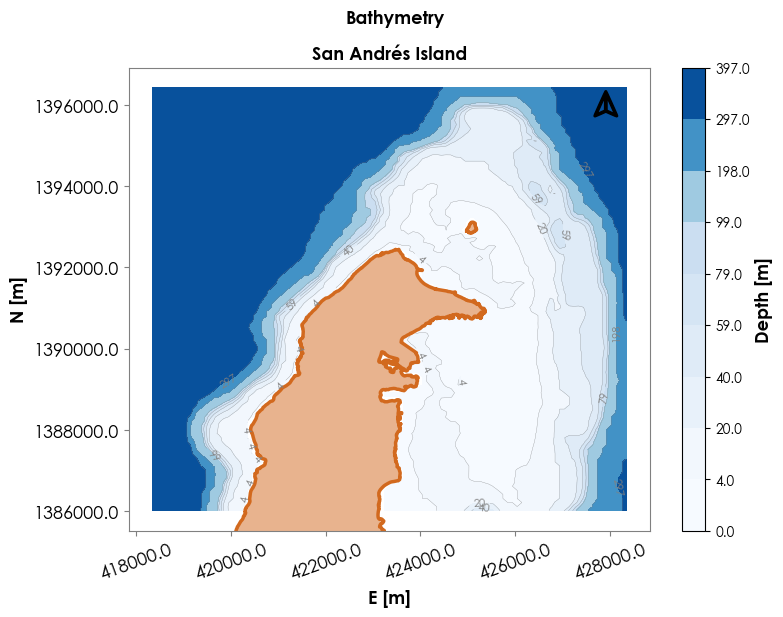

In [11]:
path = r'C:\Users\paula\Desktop\BAT_SAI_GRID_2_NORTE_V6'
# path = r'C:\Users\paula\Desktop\BAT_SAI_NORTE_3D_V2'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

# num_lineas = 31
# n_rows = 238 #83
# n_cols = 155

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

# Puntos de observación

Indices: 66, 64
Valor 1: 424740.873, Valor real 1: 424641.16
Valor 2: 1392613.575, Valor real 2: 1392537.51
Indices: 70, 82
Valor 1: 426540.873, Valor real 1: 426446.8
Valor 2: 1393013.575, Valor real 2: 1393005.91
barrera                 82     70
lagoon                  64     66


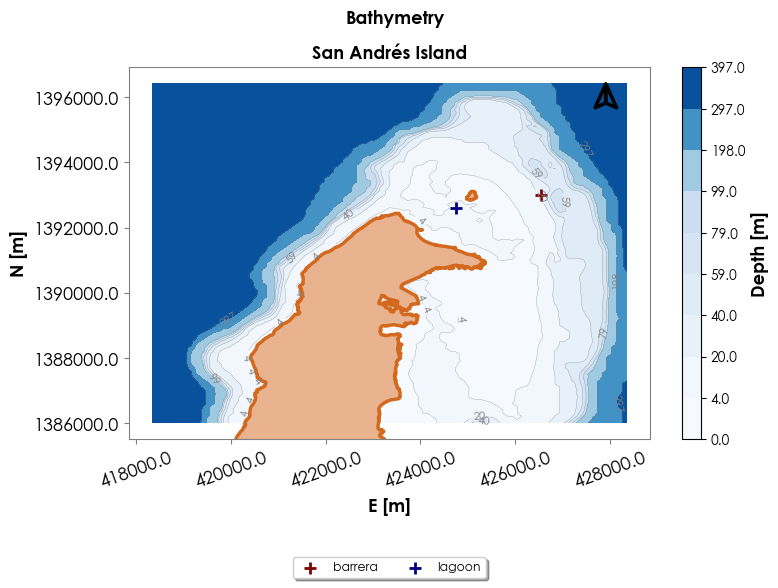

In [17]:
x_lagoon, y_lagoon =  424641.16, 1392537.51
x_barrera, y_barrera = 426446.80, 1393005.91
try:
    ind_row, ind_col = min_ind_rotated_grid(value1=x_lagoon, vector1=X, value2= y_lagoon, vector2=Y, delta=100, view_coords = True)
    list_lagoon = ['lagoon', ind_col, ind_row]
    ind_row, ind_col = min_ind_rotated_grid(value1=x_barrera, vector1=X, value2= y_barrera, vector2=Y, delta=100, view_coords = True)
    list_barrera = ['barrera', ind_col, ind_row]
    if ((len(list_lagoon) > 0) & (len(list_barrera)>0)):
        dic_points = {'ID': [list_barrera[0], list_lagoon[0]], 'Ind_X': [list_barrera[1], list_lagoon[1]], 'Ind_Y': [list_barrera[2], list_lagoon[2]]}

except:
    try:
        ind_row, ind_col = min_ind_rotated_grid(value1=x_barrera, vector1=X, value2= y_barrera, vector2=Y, delta=100, view_coords = True)
        list_barrera = ['barrera', ind_col, ind_row]
        if (len(list_barrera)>0): 
            dic_points = {'ID': [list_barrera[0]], 'Ind_X': [list_barrera[1]], 'Ind_Y': [list_barrera[2]]}

    except:
        ind_row, ind_col = min_ind_rotated_grid(value1=x_lagoon, vector1=X, value2= y_lagoon, vector2=Y, delta=100, view_coords = True)
        list_lagoon = ['lagoon', ind_col, ind_row]
        if (len(list_lagoon) > 0): 
            dic_points = {'ID': [list_lagoon[0]], 'Ind_X': [list_lagoon[1]], 'Ind_Y': [list_lagoon[2]]}


df_ind = pd.DataFrame(dic_points)
save_obs_file (path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS', df_ind = df_ind )
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450, 
           size = (8.,6.3 ), active_puntos_obs = True ,df_ind = df_ind, bottom_legend = -0.3)

## Guardar el archvio de puntos de observación

In [34]:
path = r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
save_obs_file(path = path, df_ind = obs_DataFrame (dic_points_plus= dic_points))


barrera                 80     74
cove                    15     22
PTS_1                   76     85
PTS_2                   75     85
PTS_3                   89     69
PTS_4                   92     48
PTS_5                   93     28
PTS_6                   90      7
PTS_16                  15     21
PTS_17                  28     41
PTS_18                  39     63
PTS_19                  53     81
PTS_20                  31     41
PTS_21                  29     40
PTS_22                  27     40
PTS_24                  25     40
PTS_25                  23     40
PTS_26                  20     39
PTS_27                  31     45
PTS_28                  28     45
PTS_29                  26     44
PTS_30                  27     42
PTS_31                  29     43
PTS_32                  31     43
PTS_33                  31     39
PTS_34                  30     39
PTS_35                  28     38
PTS_36                  26     38
PTS_37                  25     36
PTS_38        

# Mapa de velocidades

In [16]:
def figure_velocity(dic_vel, df_lc, time_ind, time_model, slide, colormap, size, min_level, max_level,delta, quiver_scale, quiver_lenght,active_puntos_obs, df_ind = None, bottom_legend = None):

    u = dic_vel['XComp'][time_ind,:,:]
    v = dic_vel['YComp'][time_ind,:,:]
    for i, j in zip (np.where(np.isnan(Z)==True)[0], np.where(np.isnan(Z)==True)[1]):
        u[j, i] = np.nan
        v[j, i] = np.nan        

    x = dic_vel['X'][:,:]
    y = dic_vel['Y'][:,:]
    vel = np.sqrt(u**2+v**2)
    Y_model = y[:,:][::slide, ::slide]
    X_model = x[:,:][::slide, ::slide]
    U = u[::slide,::slide]
    V = v[::slide,::slide]    
    
    # max_level = np.nanmax(vel)
    fig, ax = plt.subplots(figsize = size)
    levels = list(np.round(np.linspace(min_level, max_level, 10), 5))
    pc = ax.contourf(x, y, vel,levels = levels,cmap = colormap)
    # pc = ax.contourf(x, y, vel,cmap = colormap)
    cb=plt.colorbar(pc)
    ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')
    ax.set_xlim([np.nanmin(x)- delta, np.nanmax(x)+ delta])
    ax.set_ylim([np.nanmin(y)- delta, np.nanmax(y)+ delta])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
    cb.set_label('Velocity [m/s]',size=15, fontweight = 'semibold')
    fig_params(ax)
    ax.set_title(f'Velocity at Northeast \n of San Andres Island at {str(time_model)}',size = 16,fontweight = 'semibold')
    q = ax.quiver(X_model,Y_model,U,V,color='k',alpha=0.5, scale = quiver_scale)
    ax.quiverkey(q,0.8,0.05,quiver_lenght,label = r'1 m/s',coordinates='figure',fontproperties={'size':10})
    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)

    plt.xticks(rotation =22.5)
    plt.grid(False)

In [47]:
def figure_wave(dic_wave, df_lc, time_ind, time_model, slide, colormap, size, min_level, max_level,delta, quiver_scale, quiver_lenght,active_puntos_obs, df_ind = None, bottom_legend = None):

    u = dic_wave['XComp'][time_ind,:,:]
    v = dic_wave['YComp'][time_ind,:,:]
    for i, j in zip (np.where(np.isnan(Z)==True)[0], np.where(np.isnan(Z)==True)[1]):
        u[j, i] = np.nan
        v[j, i] = np.nan        

    x = dic_wave['X'][:,:]
    y = dic_wave['Y'][:,:]
    vel = np.sqrt(u**2+v**2)
    Y_model = y[:,:][::slide, ::slide]
    X_model = x[:,:][::slide, ::slide]
    U = u[::slide,::slide]
    V = v[::slide,::slide]    
    
    # max_level = np.nanmax(vel)
    fig, ax = plt.subplots(figsize = size)
    levels = list(np.round(np.linspace(min_level, max_level, 10), 5))
    pc = ax.contourf(x, y, vel,levels = levels,cmap = colormap)
    # pc = ax.contourf(x, y, vel,cmap = colormap)
    cb=plt.colorbar(pc)
    ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')
    ax.set_xlim([np.nanmin(x)- delta, np.nanmax(x)+ delta])
    ax.set_ylim([np.nanmin(y)- delta, np.nanmax(y)+ delta])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
    cb.set_label('H$_s$ [m]',size=15, fontweight = 'semibold')
    fig_params(ax)
    ax.set_title(f'Significante wave height \n at Northeast of San Andres Island at {str(time_model)}',size = 16,fontweight = 'semibold')
    q = ax.quiver(X_model,Y_model,U,V,color='k',alpha=0.5, scale = quiver_scale)
    ax.quiverkey(q,0.8,0.05,quiver_lenght,label = r'1 m',coordinates='figure',fontproperties={'size':10})
    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)

    plt.xticks(rotation =22.5)
    plt.grid(False)

In [18]:
def time_matlab (vec_time:float):
    """
    Función para obtener los tiempos en formato datetime 
    ----------------------------------------------------
    Input: 
    - vec_time: vector de tiempos en formato matlab
    ----------------------------------------------------
    - time: lista con los tiempos en formato datetime
    """
    time = []
    for time_i in vec_time:
        py_time = datetime.datetime.fromordinal(int(time_i)) + datetime.timedelta(days=time_i%1) - datetime.timedelta(days = 366)
        py_time = py_time +datetime.timedelta(microseconds=3)
        py_time = datetime.datetime(py_time.year, py_time.month, py_time.day, py_time.hour)
        time.append(py_time)
    return time

def read_map_mat73_file(path,name_file):
    """Esta función lee archivos .mat 
    -----------------------------------
    Input:
    - path: ruta del archivo a leer
    - name_file: nombre del archivo 
    -----------------------------------
    Output: 
    - time_model: vector de tiempos 
    - dic_: diccionario de las variables """
    data = mat73.loadmat(f'{path}\{name_file}')
    dic_ = data['data']
    time_model = time_matlab (vec_time = dic_['Time'])
    return time_model, dic_


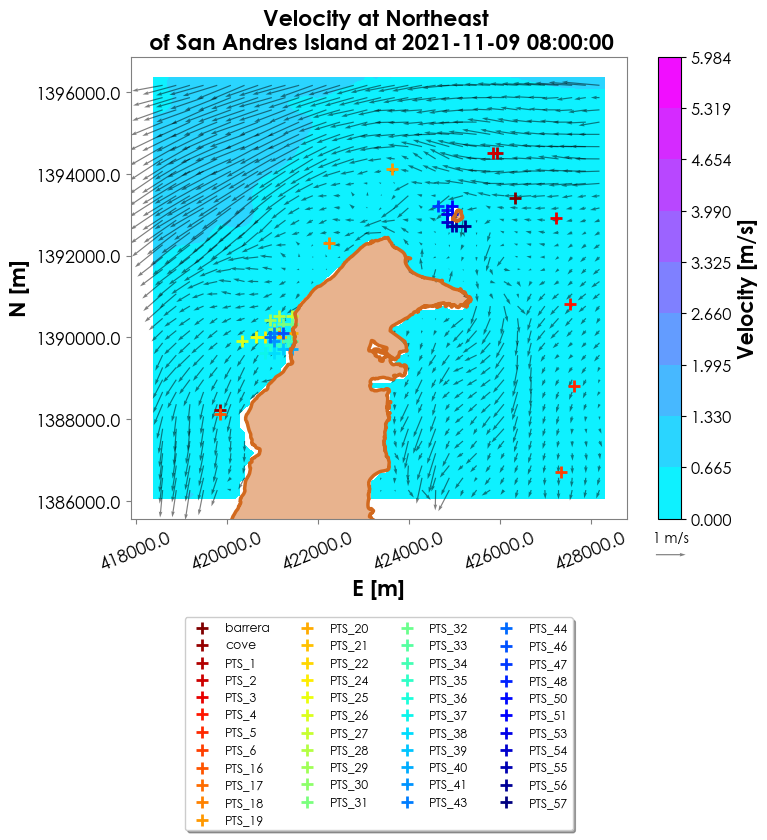

In [58]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION\MODEL_SAI_NORTE_GRID2_RECTANGULAR\BAT_SAI_GRID_2_NORTE_V2'
# name_file_vel = 'velocity_at_surface.mat'
name_file_vel = 'velocity.mat'
time_model, dic_vel = read_map_mat73_file(path = path,name_file = name_file_vel)
figure_velocity(dic_vel = dic_vel , df_lc= df_lc, time_ind = 200, time_model = time_model[200], 
                slide = 3, colormap= cm.cool, size = (8, 6), 
                min_level = 0, max_level= np.nanmax(np.sqrt(dic_vel['XComp']**2 +dic_vel['YComp']**2)),
                quiver_scale= 10, quiver_lenght= 0.6, delta = 500,
                active_puntos_obs = True, df_ind = df_ind, bottom_legend = -0.2)

In [59]:
# date_ini = datetime.datetime(2021, 11, 6, 11, 0)
# date_fin = datetime.datetime(2021, 11, 14, 5)
# ind_ini_fin = np.where((np.array(time_model )== date_ini) | (np.array(time_model) == date_fin))[0]
# ind_ini_fin

# time_ind = ind_ini_fin[0]
# # time_model = time_model[200] 
# slide = 2 
# colormap= cm.cool
# # size = (7, 8)
# size = (8, 7)
# active_puntos_obs = False
# df_ind = df_ind
# bottom_legend = -0.2
# delta = 700
# quiver_scale= 12
# quiver_lenght= 0.6
# pos_qx = 0.9
# pos_qy = 0.1
# frames = ind_ini_fin[1] - ind_ini_fin[0] #(times)


In [1]:
# from matplotlib.animation import FuncAnimation
# import matplotlib
# from IPython.display import HTML

# u = dic_vel['XComp'][ind_ini_fin[0]: ind_ini_fin[1],:,:]
# v = dic_vel['YComp'][ind_ini_fin[0]: ind_ini_fin[1],:,:]
# for k in range(len(time_model[ind_ini_fin[0]: ind_ini_fin[1]])):
#     for i, j in zip (np.where(np.isnan(Z)==True)[0], np.where(np.isnan(Z)==True)[1]):
#         u[k,j, i] = np.nan
#         v[k,j, i] = np.nan        

# x = dic_vel['X'][:,:]
# y = dic_vel['Y'][:,:]
# vel = np.sqrt(u**2+v**2)
# Y_model = y[:,:][::slide, ::slide]
# X_model = x[:,:][::slide, ::slide]
# U = u[:,::slide,::slide]
# V = v[:,::slide,::slide]    

# max_level = 3
# min_level = np.nanmin(vel)
# fig, ax = plt.subplots(figsize = size)
# levels = list(np.round(np.linspace(min_level, max_level, 10), 5))
# pc = ax.contourf(x, y, vel[time_ind, :, :],levels = levels,cmap = colormap)
# # pc = ax.contourf(x, y, vel,cmap = colormap)
# cb=plt.colorbar(pc)
# ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
# ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')
# ax.set_xlim([np.nanmin(x) - delta, np.nanmax(x)+ delta])
# ax.set_ylim([np.nanmin(y) - delta, np.nanmax(y)+ delta])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
# ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
# cb.set_label('Velocity [m/s]',size=15, fontweight = 'semibold')
# fig_params(ax)
# ax.set_title(f'Velocity at Northeast \n of San Andres Island at {str(time_model[time_ind])}',size = 16,fontweight = 'semibold')
# q = ax.quiver(X_model,Y_model,U[time_ind,:,:],V[time_ind,:,:],color='k',alpha=0.5, scale = quiver_scale)
# ax.quiverkey(q,pos_qx,pos_qy,quiver_lenght,label = r'1 m/s',coordinates='figure',fontproperties={'size':10})
# if active_puntos_obs == True:
#     colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
#     k = 0
#     for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
#         ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
#         k = k+1
#     _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
#             fancybox=True, shadow=True, ncol=4, fontsize = 9)
# ax.grid(False)
# ax.tick_params(axis='x', labelrotation = 20)

# def update(frame):
#     ax.clear()
#     ax.set_xlim([np.nanmin(x)-delta, np.nanmax(x)+delta])
#     ax.set_ylim([np.nanmin(y)-delta, np.nanmax(y)+delta])
#     ax.set_title(f'Velocity at Northeast \n of San Andres Island at {str(time_model[frame + time_ind])}',size = 16,fontweight = 'semibold')
#     ax.contourf(x, y, vel[frame, :, :],levels = levels,cmap = colormap)
#     q = ax.quiver(X_model,Y_model,U[frame,:,:],V[frame,:,:],color='k',alpha=0.5, scale = quiver_scale)
#     ax.quiverkey(q,pos_qx,pos_qy,quiver_lenght,label = r'1 m/s',coordinates='figure',fontproperties={'size':10})
#     ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
#     ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
#     ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
#     ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax.tick_params(axis='x', labelrotation = 20)
#     fig_params(ax)
#     ax.grid(False)
#     if active_puntos_obs == True:
#         colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
#         k = 0
#         for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
#             ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
#             k = k+1
#         _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
#                 fancybox=True, shadow=True, ncol=4, fontsize = 9)


# plt.xticks(rotation =22.5)
# plt.grid(False)
# fig.tight_layout()

# # Creamos la animación
# matplotlib.rcParams['animation.embed_limit'] = 2**128
# anim = FuncAnimation(fig, update, frames=frames, interval=100)

# # Mostramos el GIF en el código
# html = anim.to_jshtml()
# HTML(html)

In [2]:
# anim.save(f'{name_file_vel[:-4]}_tem_wave.gif', writer='pillow')
# # MovieWriter imagemagick unavailable; using Pillow instead.

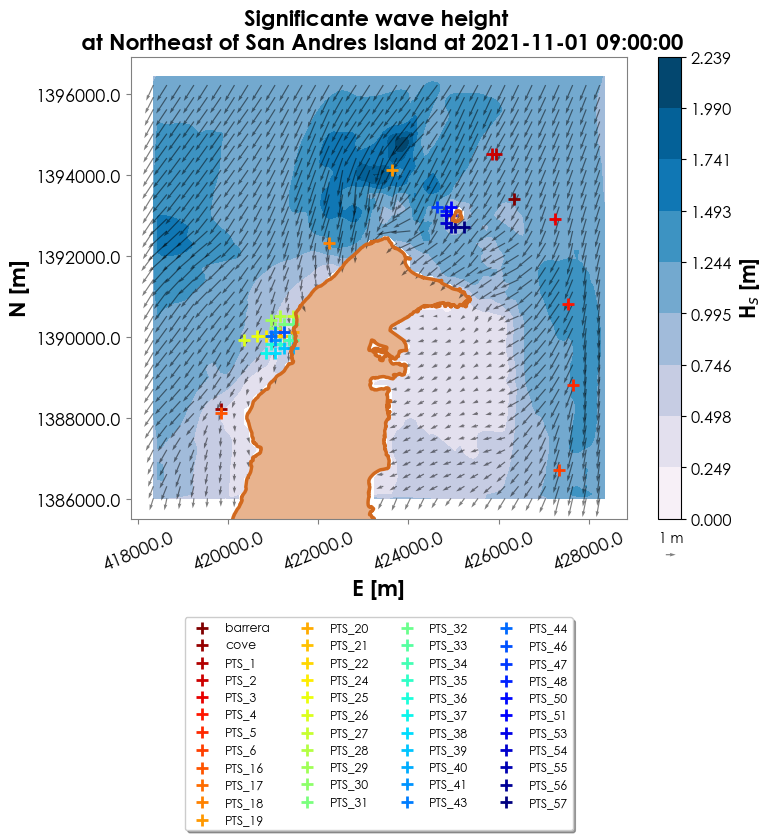

In [48]:
path = path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION\MODEL_SAI_NORTE_GRID2_RECTANGULAR\BAT_SAI_GRID_2_NORTE_V1'
name_file_wave = 'hsig_wave_vector_mean_direction.mat'
time_model, dic_wave = read_map_mat73_file(path = path,name_file = name_file_wave)
figure_wave(dic_wave = dic_wave , df_lc= df_lc, time_ind = 10, time_model = time_model[10], 
                slide = 3, colormap= cm.PuBu, size = (8, 6), 
                min_level = 0, max_level= np.nanmax(np.sqrt(dic_wave['XComp']**2 +dic_wave['YComp']**2)),
                quiver_scale= 30, quiver_lenght= 0.6, delta = 500,
                active_puntos_obs = True, df_ind = df_ind, bottom_legend = -0.2)
# figure_velocity(dic_vel = dic_vel , df_lc= df_lc, time_ind = 10, time_model = time_model[10], 
#                 slide = 3, colormap= cm.cool, size = (8, 6), 
#                 min_level = 0, max_level= np.nanmax(np.sqrt(dic_vel['XComp']**2 +dic_vel['YComp']**2)),
#                 quiver_scale= 8, quiver_lenght= 0.6, delta = 500,
#                 active_puntos_obs = True, df_ind = df_ind, bottom_legend = -0.2)

In [3]:
# date_ini = datetime.datetime(2021, 11, 6, 11, 0)
# date_fin = datetime.datetime(2021, 11, 14, 5)
# ind_ini_fin = np.where((np.array(time_model )== date_ini) | (np.array(time_model) == date_fin))[0]
# ind_ini_fin

# time_ind = ind_ini_fin[0]
# slide = 2 
# # colormap= cm.PuBu
# colormap= cm.jet
# size = (8, 7)
# # size = (7, 8) 
# active_puntos_obs = False
# df_ind = df_ind
# bottom_legend = -0.2
# delta = 500
# quiver_scale= 30
# quiver_lenght= 0.6
# pos_qx = 0.9
# pos_qy = 0.1
# frames = ind_ini_fin[1] - ind_ini_fin[0] #(times)

In [4]:
# from matplotlib.animation import FuncAnimation
# import matplotlib
# from IPython.display import HTML

# u = dic_wave['XComp'][ind_ini_fin[0]: ind_ini_fin[1],:,:]
# v = dic_wave['YComp'][ind_ini_fin[0]: ind_ini_fin[1],:,:]
# for k in range(len(time_model[ind_ini_fin[0]: ind_ini_fin[1]])):
#     for i, j in zip (np.where(np.isnan(Z)==True)[0], np.where(np.isnan(Z)==True)[1]):
#         u[k,j, i] = np.nan
#         v[k,j, i] = np.nan        

# x = dic_wave['X'][:,:]
# y = dic_wave['Y'][:,:]
# vel = np.sqrt(u**2+v**2)
# Y_model = y[:,:][::slide, ::slide]
# X_model = x[:,:][::slide, ::slide]
# U = u[:,::slide,::slide]
# V = v[:,::slide,::slide]    

# max_level = 2.55
# min_level = np.nanmin(vel)
# fig, ax = plt.subplots(figsize = size)
# levels = list(np.round(np.linspace(min_level, max_level, 20), 1))
# pc = ax.contourf(x, y, vel[time_ind, :, :],levels = levels,cmap = colormap)
# # pc = ax.contourf(x, y, vel,cmap = colormap)
# cb=plt.colorbar(pc)
# ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
# ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')
# ax.set_xlim([np.nanmin(x) - delta, np.nanmax(x)+ delta])
# ax.set_ylim([np.nanmin(y) - delta, np.nanmax(y)+ delta])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
# ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
# cb.set_label('H$_s$ [m]',size=15, fontweight = 'semibold')
# fig_params(ax)
# ax.set_title(f'Significant wave height \n at Northeast of San Andres Island at {str(time_model[time_ind])}',size = 16,fontweight = 'semibold')
# q = ax.quiver(X_model,Y_model,U[time_ind,:,:],V[time_ind,:,:],color='k',alpha=0.5, scale = quiver_scale)
# ax.quiverkey(q,pos_qx,pos_qy,quiver_lenght,label = r'1 m',coordinates='figure',fontproperties={'size':10})
# if active_puntos_obs == True:
#     colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
#     k = 0
#     for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
#         ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
#         k = k+1
#     _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
#             fancybox=True, shadow=True, ncol=4, fontsize = 9)
# ax.grid(False)
# ax.tick_params(axis='x', labelrotation = 20)

# def update(frame):
#     ax.clear()
#     ax.set_xlim([np.nanmin(x)-delta, np.nanmax(x)+delta])
#     ax.set_ylim([np.nanmin(y)-delta, np.nanmax(y)+delta])
#     ax.set_title(f'Significant wave height \n at Northeast of San Andres Island at {str(time_model[frame + time_ind])}',size = 16,fontweight = 'semibold')
#     ax.contourf(x, y, vel[frame, :, :],levels = levels,cmap = colormap)
#     q = ax.quiver(X_model,Y_model,U[frame,:,:],V[frame,:,:],color='k',alpha=0.5, scale = quiver_scale)
#     ax.quiverkey(q,pos_qx,pos_qy,quiver_lenght,label = r'1 m',coordinates='figure',fontproperties={'size':10})
#     ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
#     ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)
#     ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
#     ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax.tick_params(axis='x', labelrotation = 20)
#     fig_params(ax)
#     ax.grid(False)
#     if active_puntos_obs == True:
#         colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
#         k = 0
#         for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
#             ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
#             k = k+1
#         _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
#                 fancybox=True, shadow=True, ncol=4, fontsize = 9)


# plt.xticks(rotation =22.5)
# plt.grid(False)
# fig.tight_layout()

# # Creamos la animación
# matplotlib.rcParams['animation.embed_limit'] = 2**128
# anim = FuncAnimation(fig, update, frames=frames, interval=100)

# # Mostramos el GIF en el código
# html = anim.to_jshtml()
# HTML(html)

In [5]:
# anim.save(f'{name_file_wave[:-4]}_wave_temp.gif', writer='pillow')

# HYCOM DATA 

In [2]:
def read_hycom_data(path, name_file):
    data = Dataset(f'{path}\{name_file}', 'r')
    lat = np.array(data.variables['latitude'][:])
    lon = np.array(data.variables['longitude'][:])
    nctime = np.array(data.variables['time'][:])
    t_unit = data.variables['time'].units
    t_cal = data.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    time = np.array([datetime.datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    # Cambiar la zona horaria utc 0 a utc -5
    utc = pytz.utc
    col_zone = timezone('America/Bogota')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    salt = np.array(data.variables['salinity'][:])
    salt[salt==-30000] = np.nan
    temp = np.array(data.variables['water_temp'][:])
    temp[temp==-30000] = np.nan
    depth = np.array(data.variables['depth'][:]) 

    dic_ = {'time':time,'lat': lat, 'lon': lon,'depth': depth,  'salt': salt, 'temp': temp }
    return dic_

In [12]:
def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)
    return ind

In [13]:
def constituten(c, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd, idate_ini, idate_fin):
    """
    ------------input------------------------
    c: arreglo de la propiedad constitutiva (temp / sal) 
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    idate_ini: fecha incial de modelación 
    idate_fin: fecha final de la modelación 
    
    ------------output----------------------------
    constituen: serie de la propiedad constitutiva a la profundida deseada
    
    """
    c= c[idate_ini:idate_fin,np.where(depth_s==depth_bd)[0][0], np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    return c

In [14]:
def time_settings(date_ini, date_fin, time):
    """
    Esta función revuelve los mintos y los índicies de la fecha inicial y final del periodo del modelo
    ----------------------------------------------------------------------------------------------------
    Input: 
    - date_ini: fecha inicial del modelo
    - date_fin: fecha final del modelo
    - time: vector de tiempos de la base de datos 
    ----------------------------------------------------------------------------------------------------
    Output: 
    - ind_ini_fin: indices de la fecha inicial y final que coincieden con los tiempos de la base de datos 
    - minutes: minutos contados a partir de la fecha incial 
    """
    ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
    time_d3d = time[ind_ini_fin[0]:ind_ini_fin[1]]
    minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
    return ind_ini_fin, minutes

In [15]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file_hycom = 'Hycom_oct21_nov15_2021_6_temp_sal_2.nc'
dic_prop = read_hycom_data(path = path, name_file = name_file_hycom)

In [16]:
# Time split
date_ini = datetime.datetime(2021,11,1,1,0) # Fechas inicial de modelación
date_fin = datetime.datetime(2021,11,14,19,0) # Fechas final de modelación
ind_ini_fin, minutes = time_settings(date_ini = date_ini , date_fin = date_fin , time = dic_prop['time'])


n_capas = int(input('Ingrese el numero de capas a modelar',))
grid_type = str(input('Ingrese el tipo de malla (s: sigma, z: zeta)',))
if n_capas == 1: 
    grid_type = 's'

if grid_type == 's':
    depth_layer = list([dic_prop['depth'][:n_capas]][0])
elif grid_type=='z':
    depth_layer = list([dic_prop['depth'][:n_capas]][0])[::-1]

print(depth_layer)

[400.0, 300.0, 200.0, 125.0, 90.0, 70.0, 50.0, 40.0, 30.0, 20.0, 12.0, 8.0, 4.0, 0.0]


Indice: 3 , Valor: 278.32000732421875 , Valor real: 278.2584066608964
Indice: 14 , Valor: 12.640000343322754 , Valor real: 12.62896524385627
Indice: 4 , Valor: 278.4000244140625 , Valor real: 278.33666950517244
Indice: 14 , Valor: 12.640000343322754 , Valor real: 12.629171281175166


<AxesSubplot:>

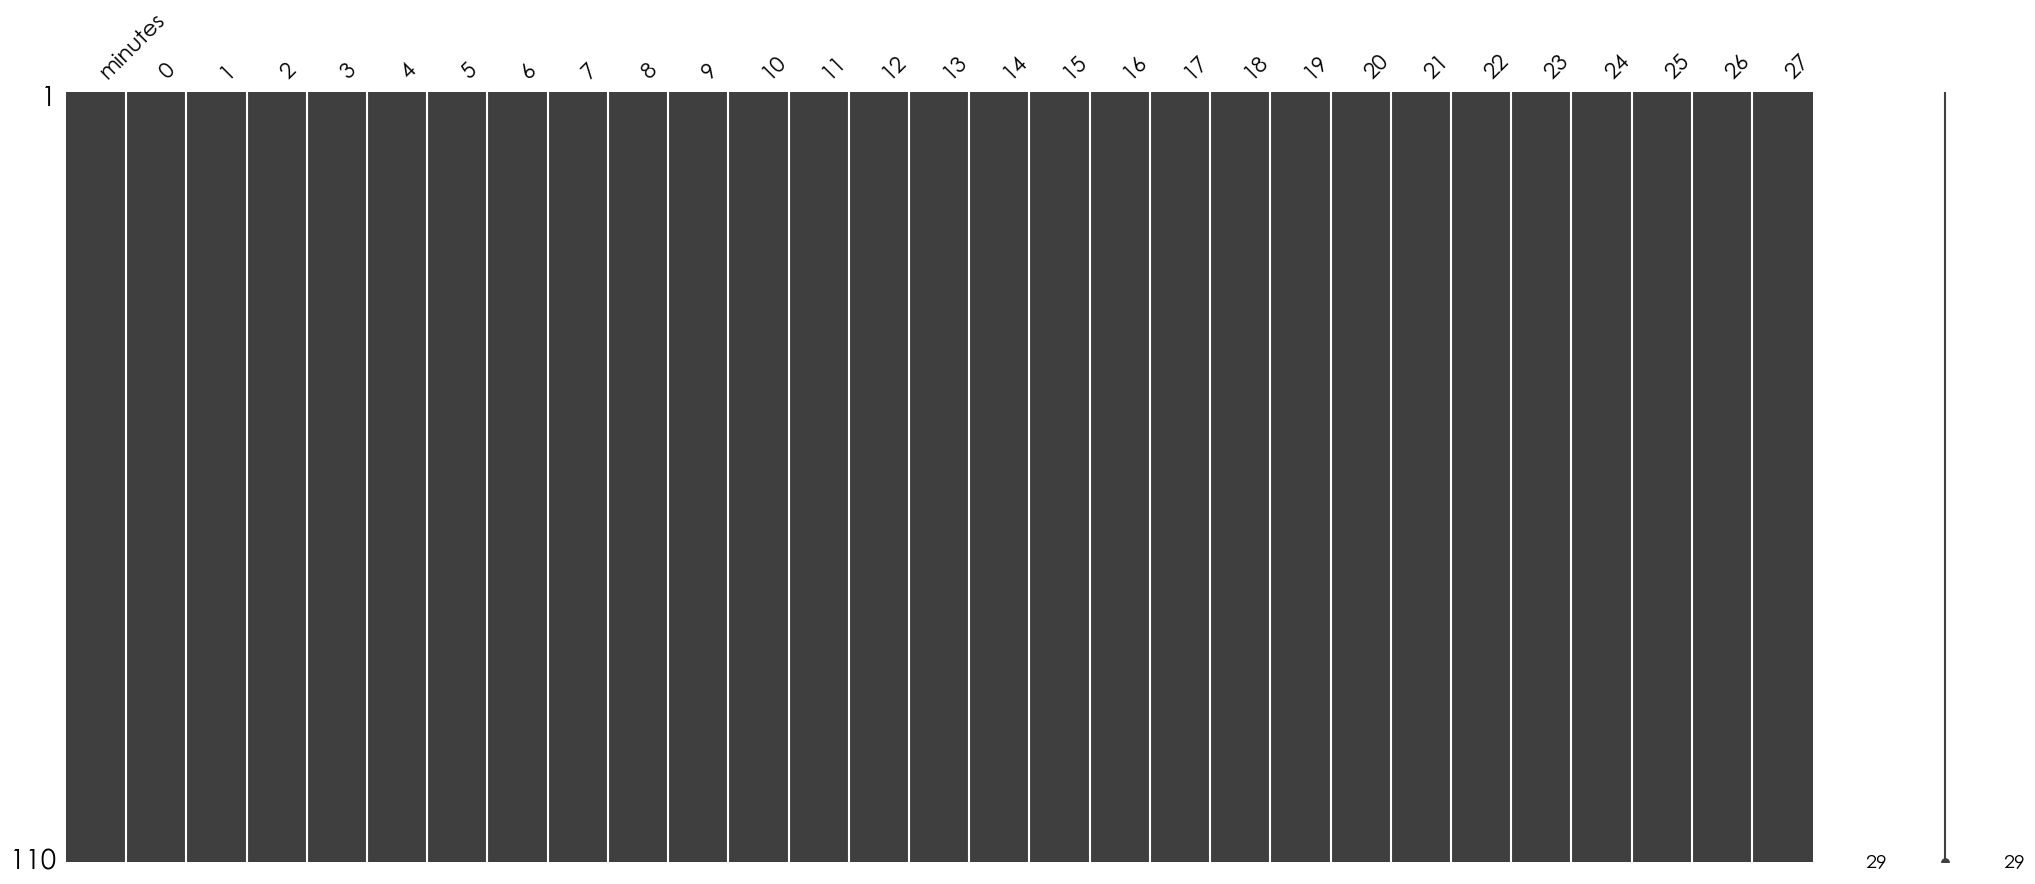

In [17]:
# Frontera más al norte 
Px_bd1_A, Py_bd1_A = X[84,0], Y[84,0]
# Px_bd1_A, Py_bd1_A = X[0,79], Y[0,79]
lon_bd1_A, lat_bd1_A = coord_wgs(Px_bd1_A, Py_bd1_A)
ilon_bd1_A = min_ind(value=lon_bd1_A, vector=dic_prop['lon'], delta=0.08)
ilat_bd1_A = min_ind(value=lat_bd1_A, vector=dic_prop['lat'], delta=0.04)  
Px_bd1_B, Py_bd1_B = X[84, 85], Y[84,85]
# Px_bd1_B, Py_bd1_B = X[79, 79], Y[79,79]
lon_bd1_B, lat_bd1_B = coord_wgs(Px_bd1_B, Py_bd1_B) 
ilon_bd1_B = min_ind(value=lon_bd1_B, vector=dic_prop['lon'], delta=0.08)
ilat_bd1_B = min_ind(value=lat_bd1_B, vector=dic_prop['lat'], delta=0.03) 

dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# df_salt[0] = df_salt[1]-0.1
msno.matrix(df_salt)

In [66]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_norte.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

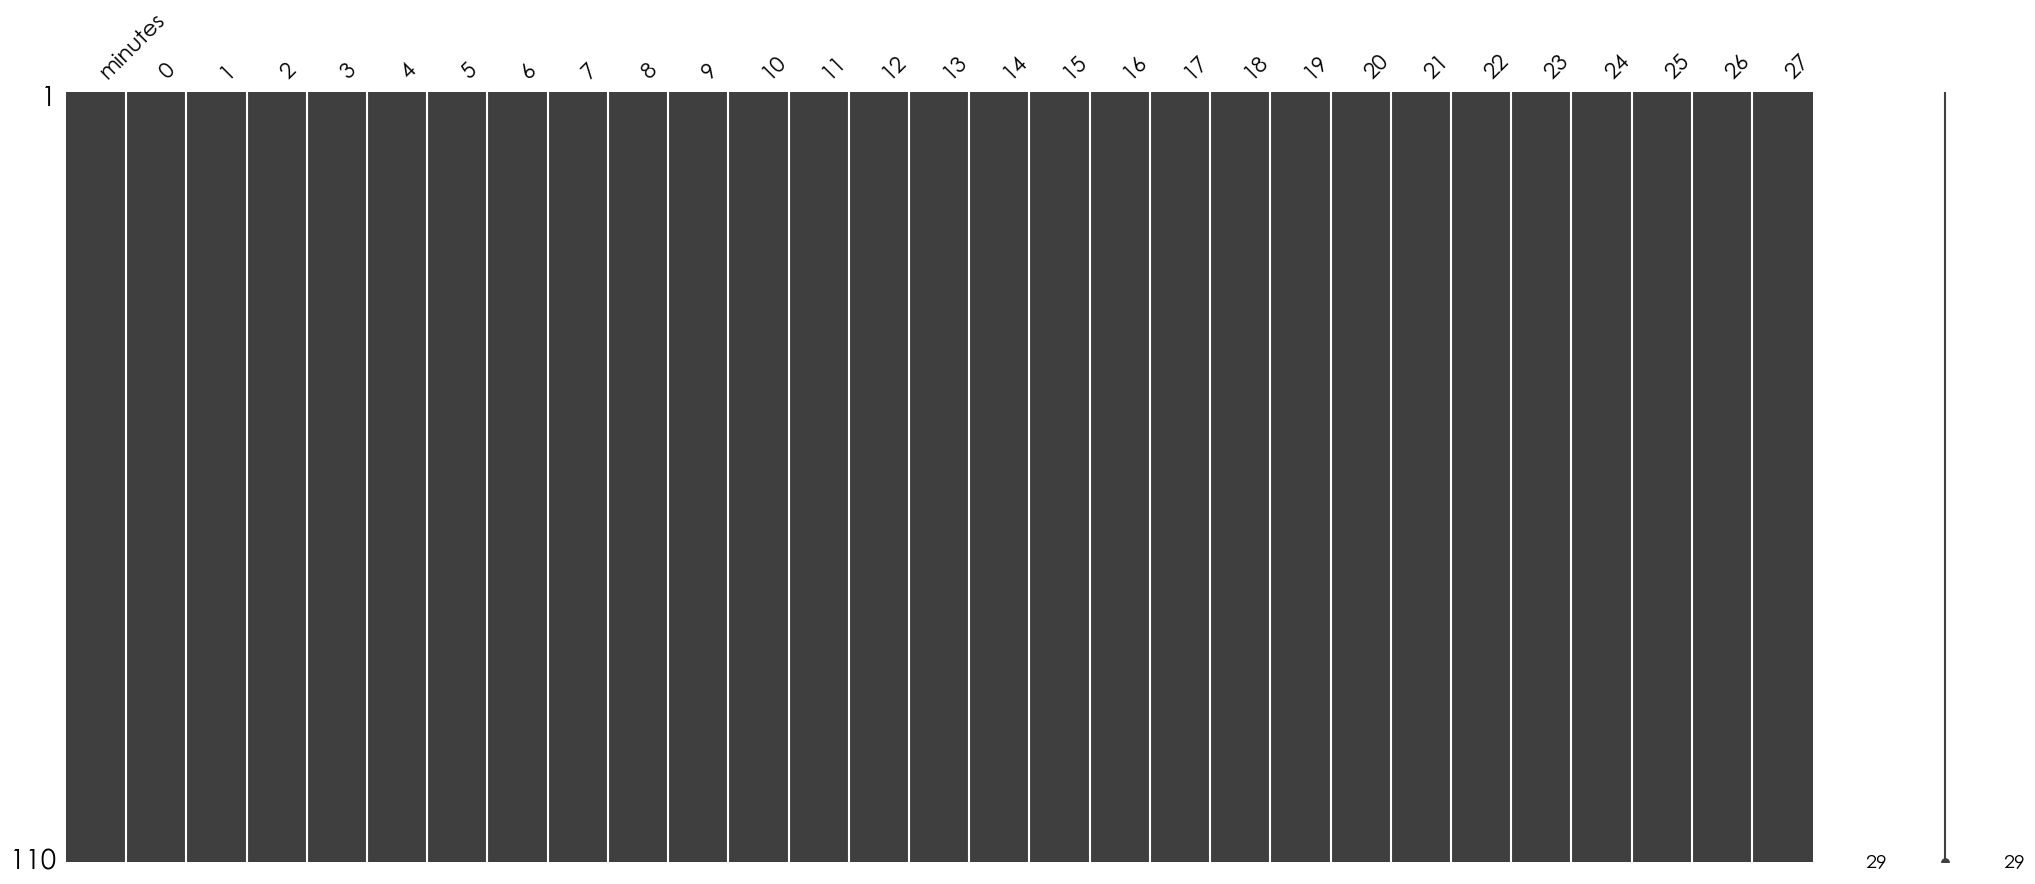

In [67]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd1_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd1_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# df_temp[0] = df_temp[1]-1
msno.matrix(df_temp)

In [68]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_norte.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

Indice: 3 , Valor: 278.32000732421875 , Valor real: 278.2586248274693
Indice: 12 , Valor: 12.5600004196167 , Valor real: 12.553010469498302
Indice: 4 , Valor: 278.4000244140625 , Valor real: 278.3359441758468
Indice: 12 , Valor: 12.5600004196167 , Valor real: 12.55321295216112


<AxesSubplot:>

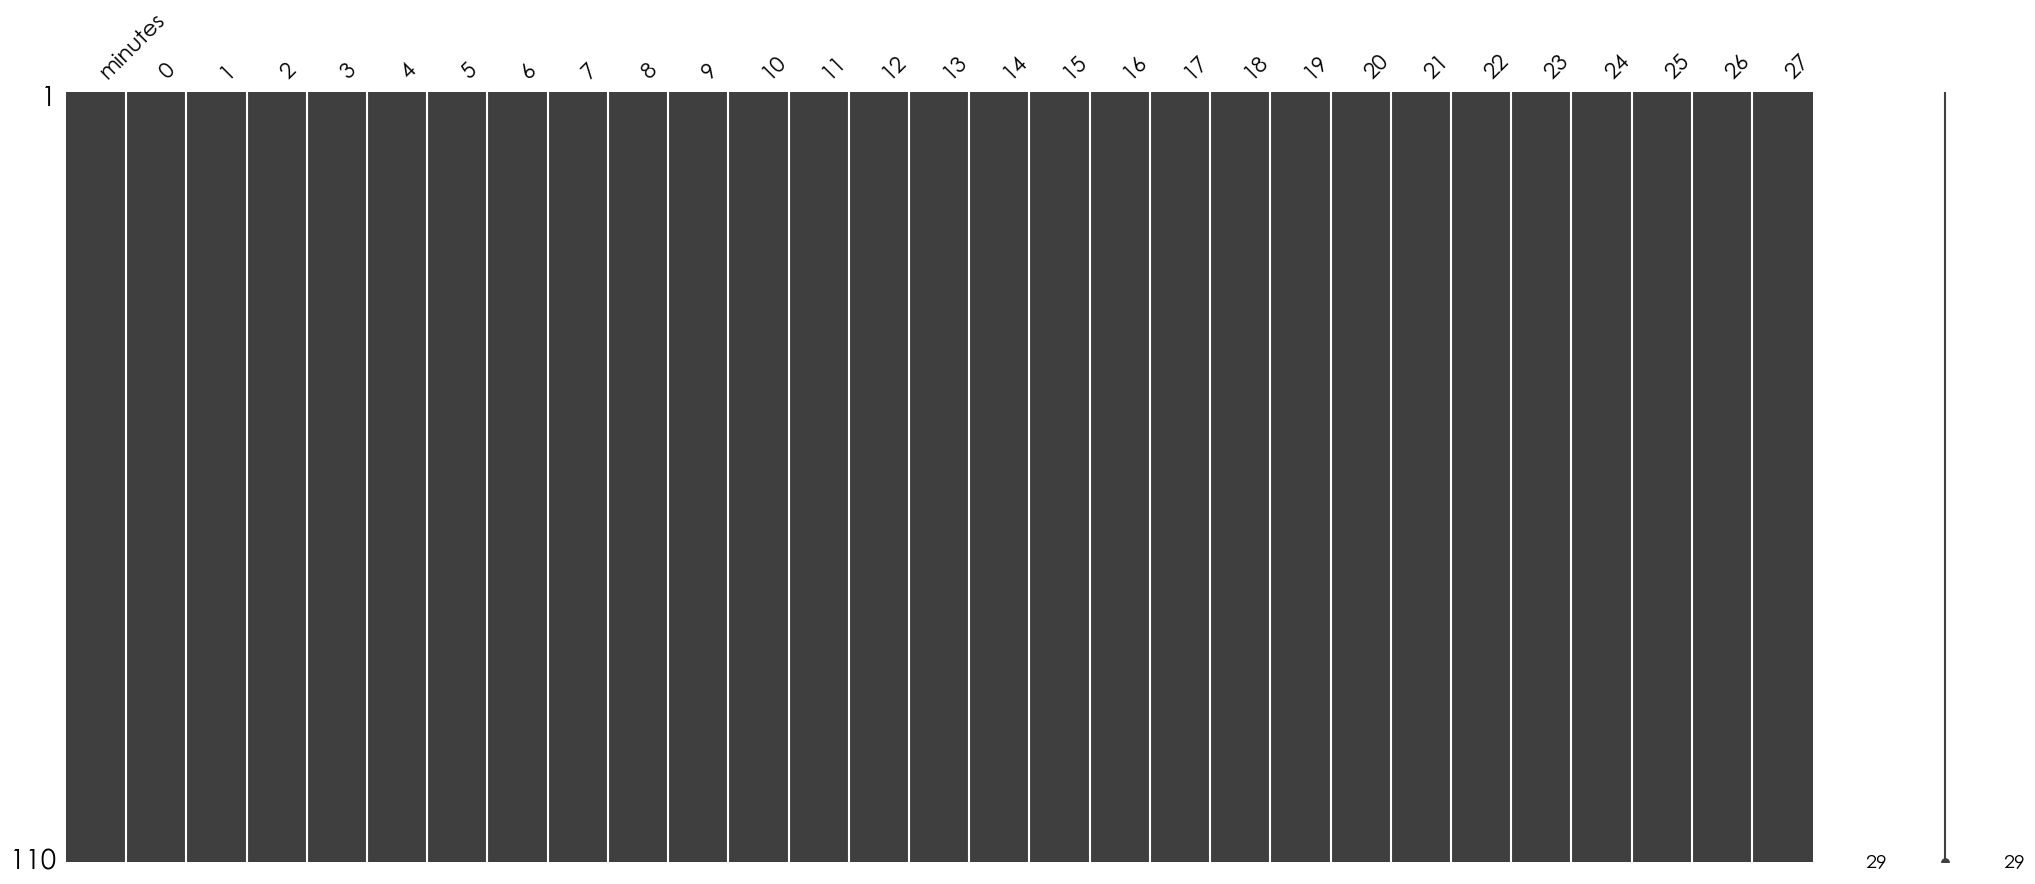

In [18]:
# Frontera más al sur 
Px_bd2_A, Py_bd2_A = X[0, 0], Y[0,0]
# Px_bd2_A, Py_bd2_A = X[0, 84], Y[0,84]
lon_bd2_A, lat_bd2_A = coord_wgs(Px_bd2_A, Py_bd2_A)
ilon_bd2_A = min_ind(value=lon_bd2_A, vector=dic_prop['lon'], delta=0.08)
ilat_bd2_A = min_ind(value=lat_bd2_A, vector=dic_prop['lat'], delta=0.04) 
Px_bd2_B, Py_bd2_B = X[0, 84], Y[0,84]
# Px_bd2_B, Py_bd2_B = X[0, 0], Y[0,0]
lon_bd2_B, lat_bd2_B = coord_wgs(Px_bd2_B, Py_bd2_B)
ilon_bd2_B = min_ind(value=lon_bd2_B, vector=dic_prop['lon'], delta=0.08)
ilat_bd2_B = min_ind(value=lat_bd2_B, vector=dic_prop['lat'], delta=0.04) 


dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# # df_salt[18] = df_salt[19] -0.1
# df_salt[17] = df_salt[18] -0.1
# # df_salt[1] = df_salt[2] -0.1
# df_salt[0] = df_salt[1] -0.1
msno.matrix(df_salt)

In [85]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_sur_oeste.bcc'
# name_file = 'salt_sur_este.bcc'

np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

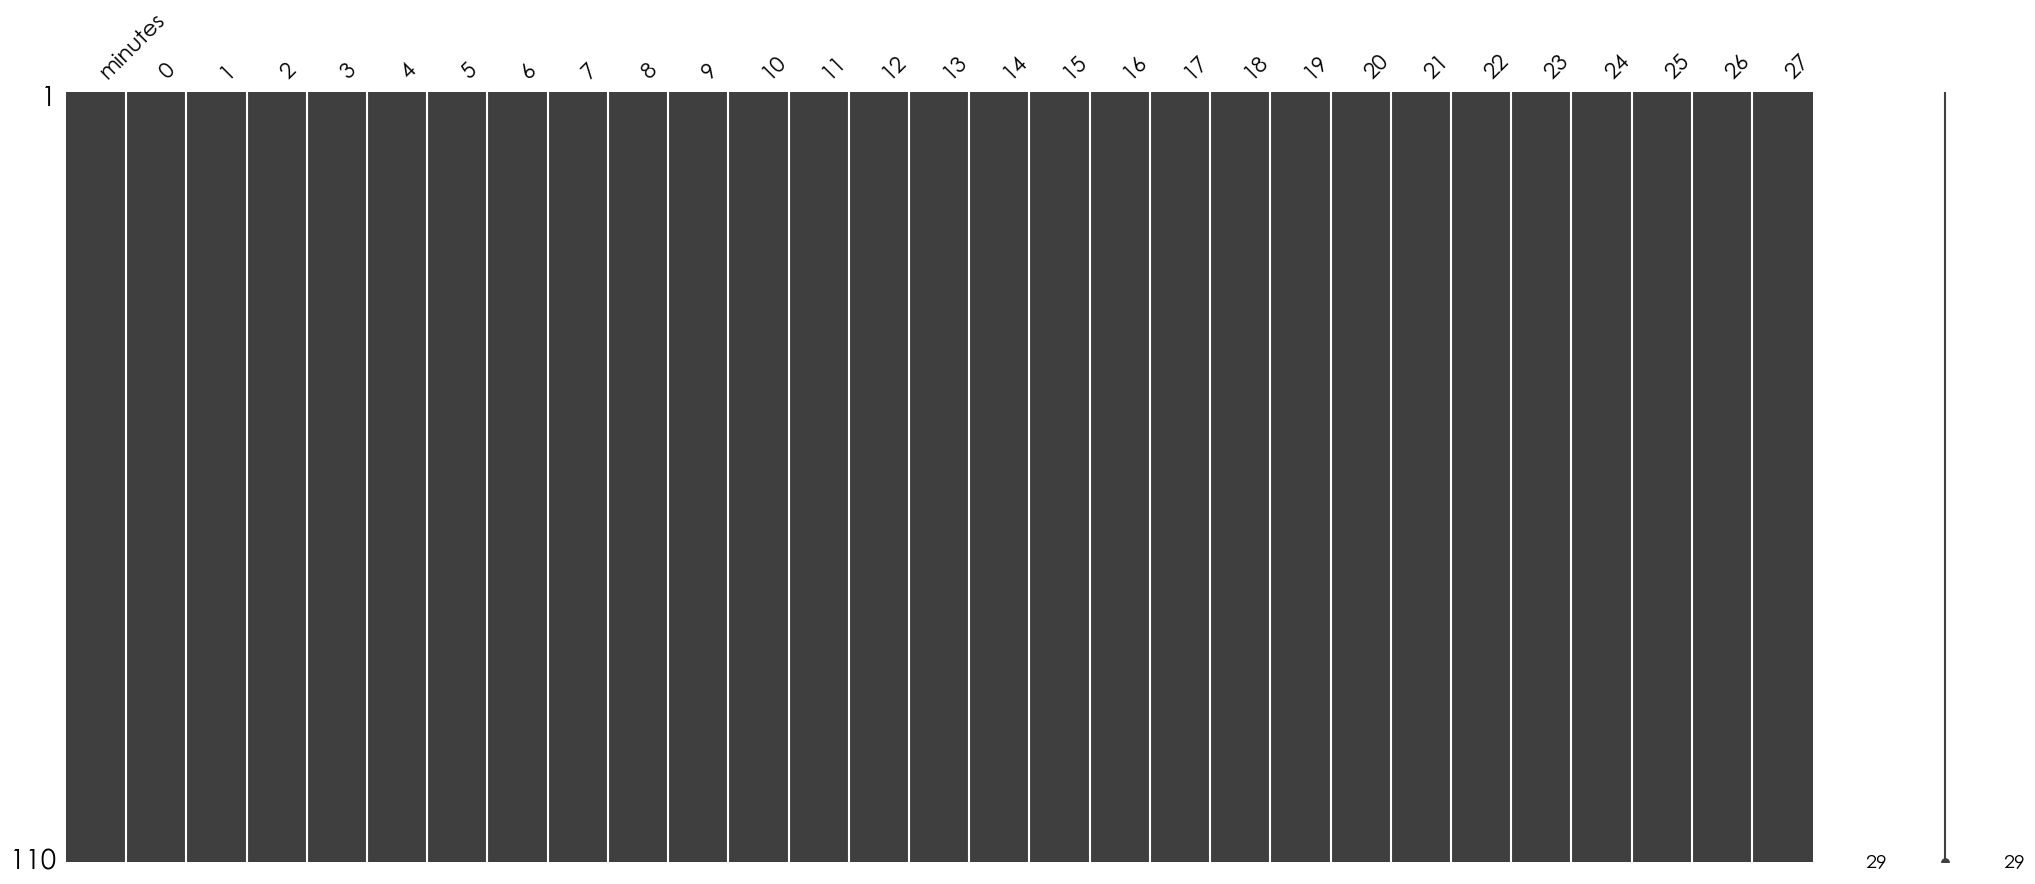

In [86]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd2_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd2_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# # df_temp[18] = df_temp[19] -1
# df_temp[17] = df_temp[18] -1
# # df_temp[1] = df_temp[2] -1
# df_temp[0] = df_temp[1] -1
msno.matrix(df_temp)

In [87]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_sur_oeste.bcc'
# name_file = 'temp_sur_este.bcc'

np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

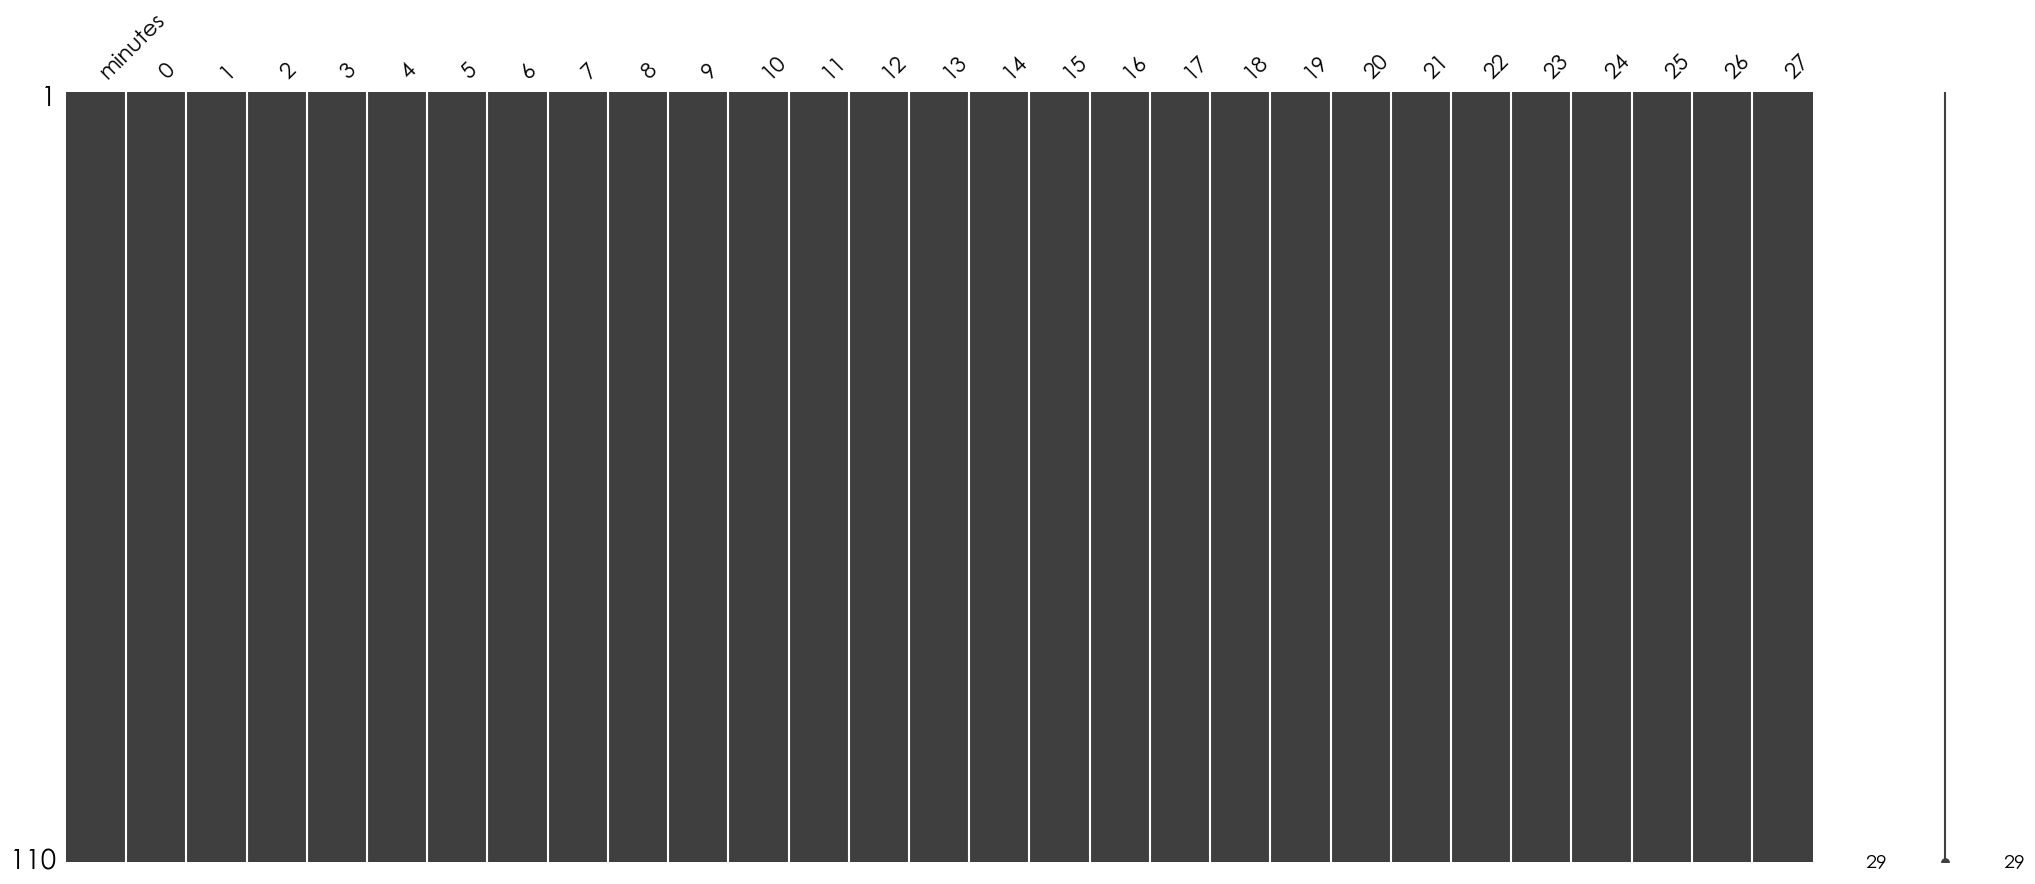

In [19]:
# más ESTE
ilat_bd3_A = ilat_bd2_B
ilon_bd3_A = ilon_bd2_B

ilat_bd3_B = ilat_bd1_B
ilon_bd3_B = ilon_bd1_B

dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# df_salt[1] = df_salt[2] -0.1
# df_salt[0] = df_salt[1] -0.1
msno.matrix(df_salt)

In [20]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_este.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

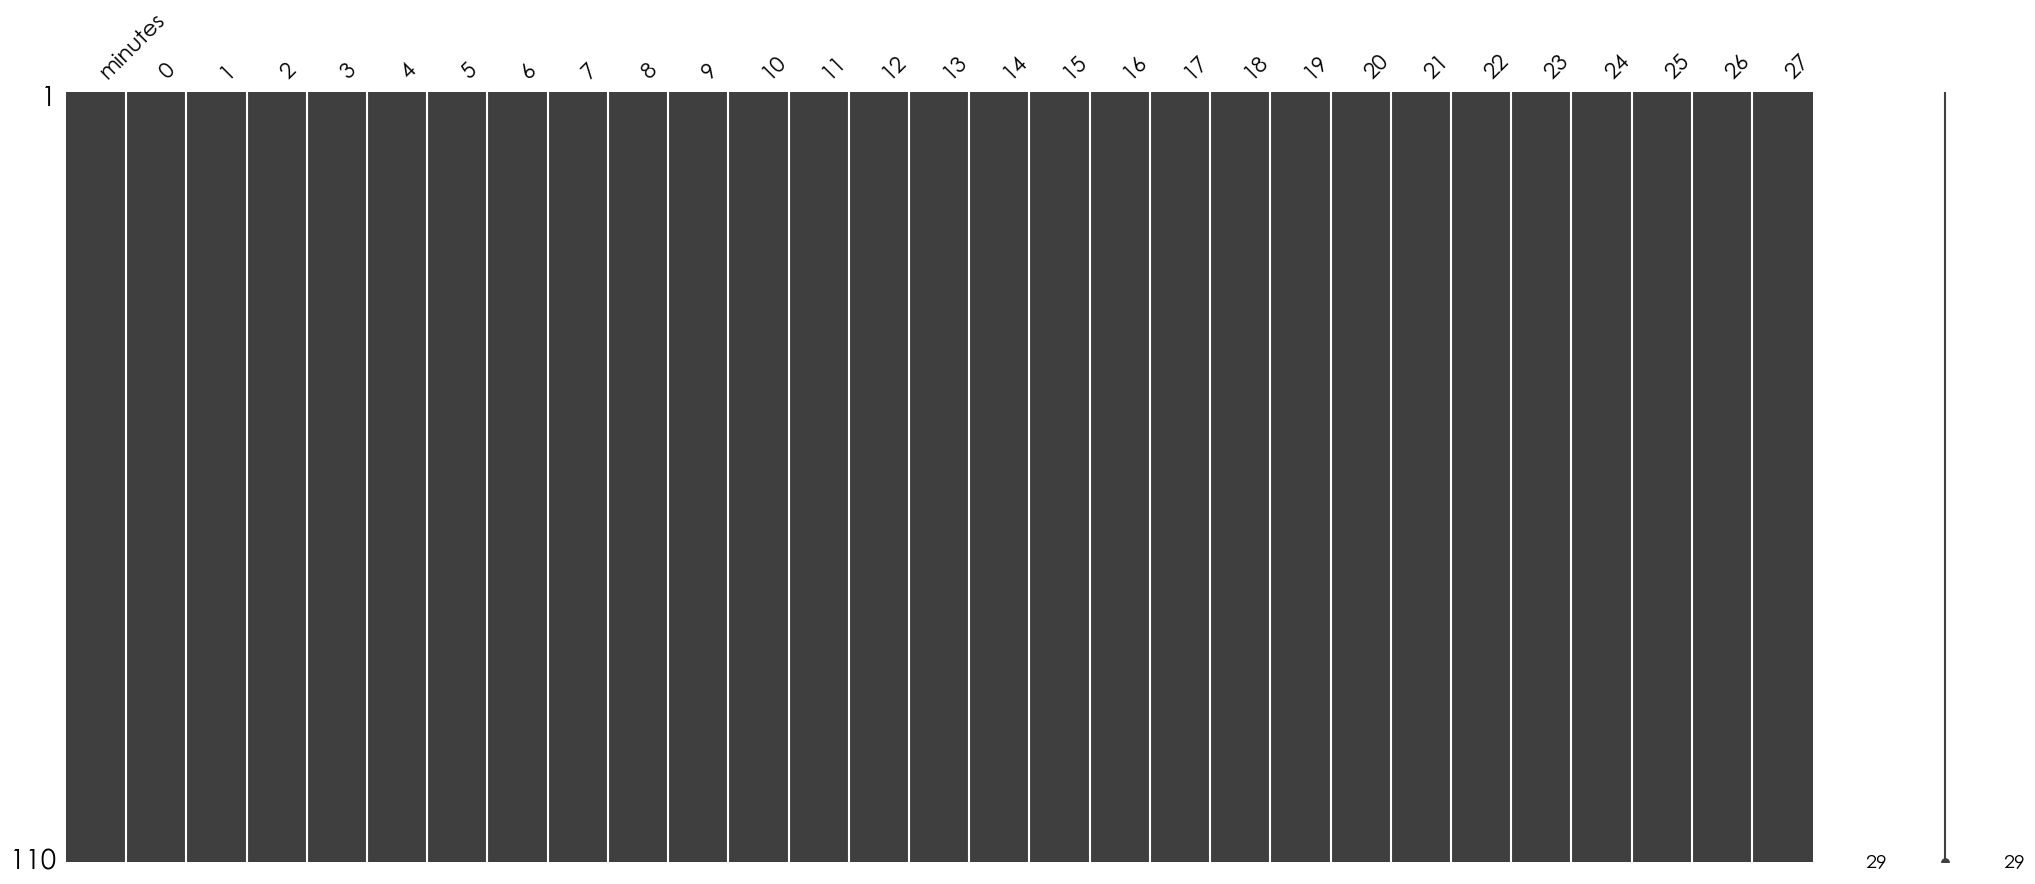

In [21]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd3_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd3_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# # df_temp[1] = df_temp[2] -1
# df_temp[0] = df_temp[1] -1
msno.matrix(df_temp)

In [22]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_este.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

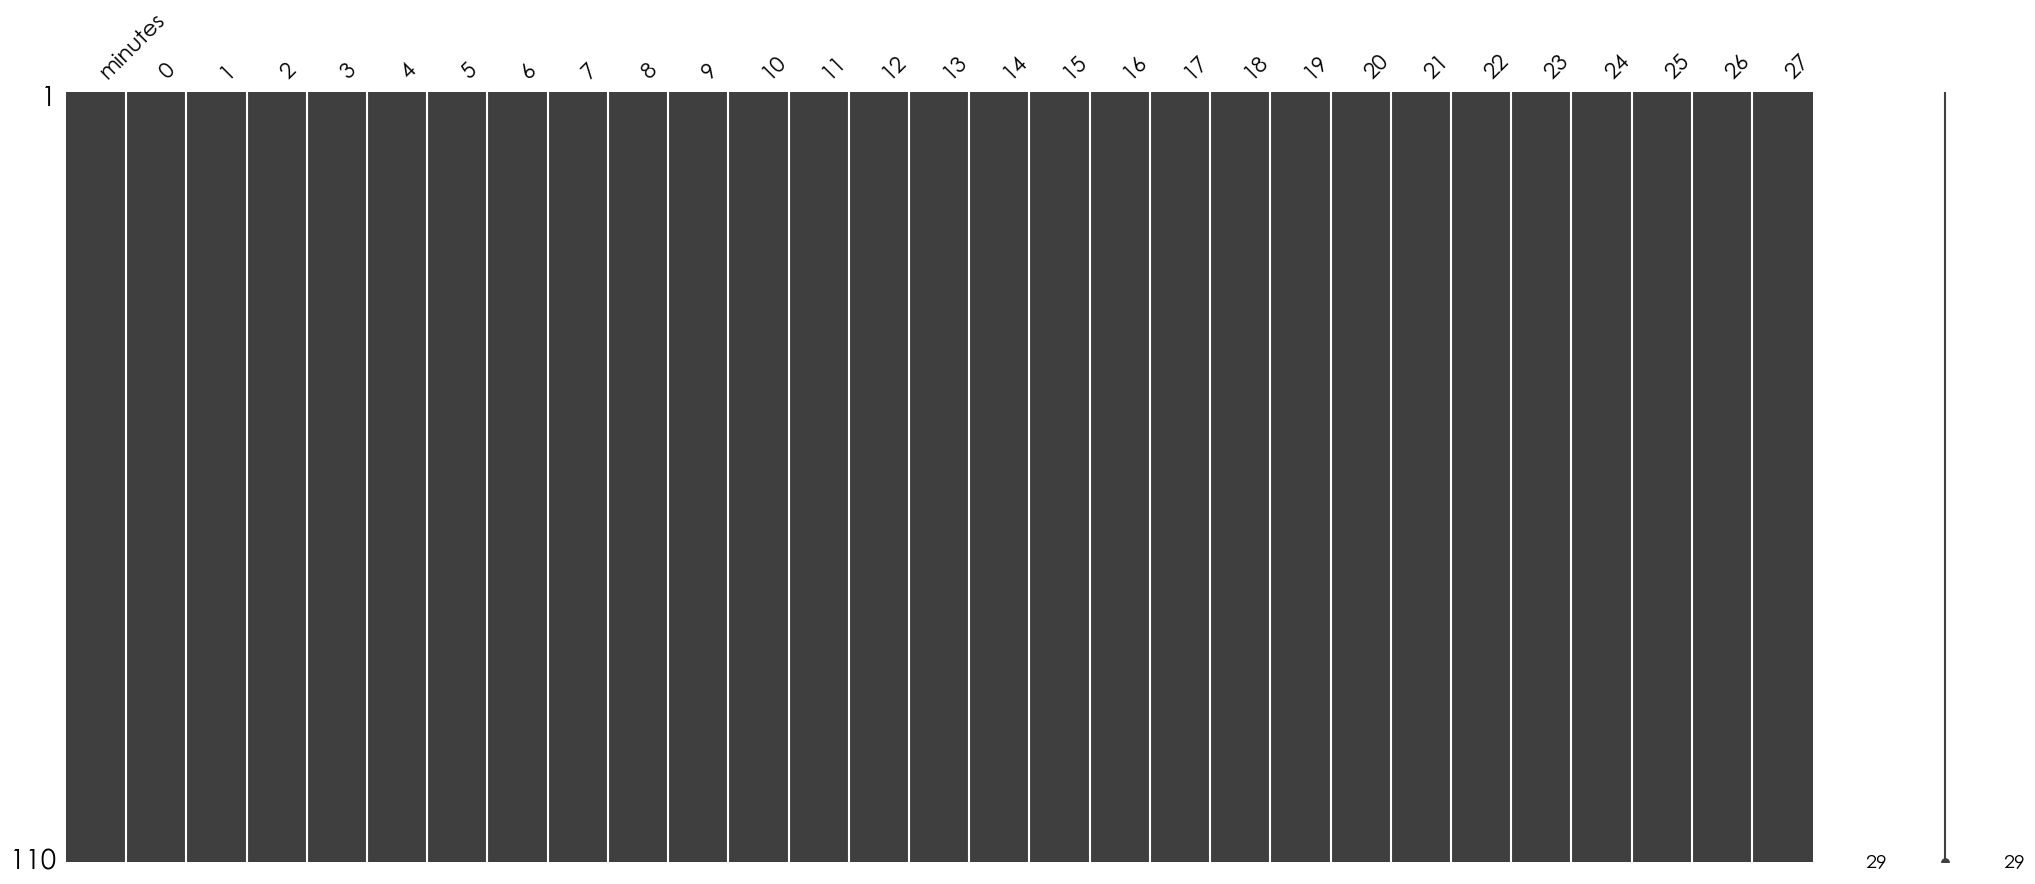

In [23]:
# más OESTE
ilat_bd4_A = ilat_bd2_A
ilon_bd4_A = ilon_bd2_A

ilat_bd4_B = ilat_bd1_A
ilon_bd4_B = ilon_bd1_A

dic_salt = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['salt'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_salt.update({n_capas + j:c})

df_salt = pd.DataFrame(dic_salt)
df_salt.insert(loc= 0, column = 'minutes', value = minutes)
# df_salt[17] = df_salt[18] -0.1
# df_salt[1] = df_salt[2] -0.1
# df_salt[0] = df_salt[1] -0.1
msno.matrix(df_salt)

In [24]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_oeste.bcc'
np.savetxt(path+'/'+name_file, df_salt.values, delimiter=' ', fmt = "%+15.7e")

<AxesSubplot:>

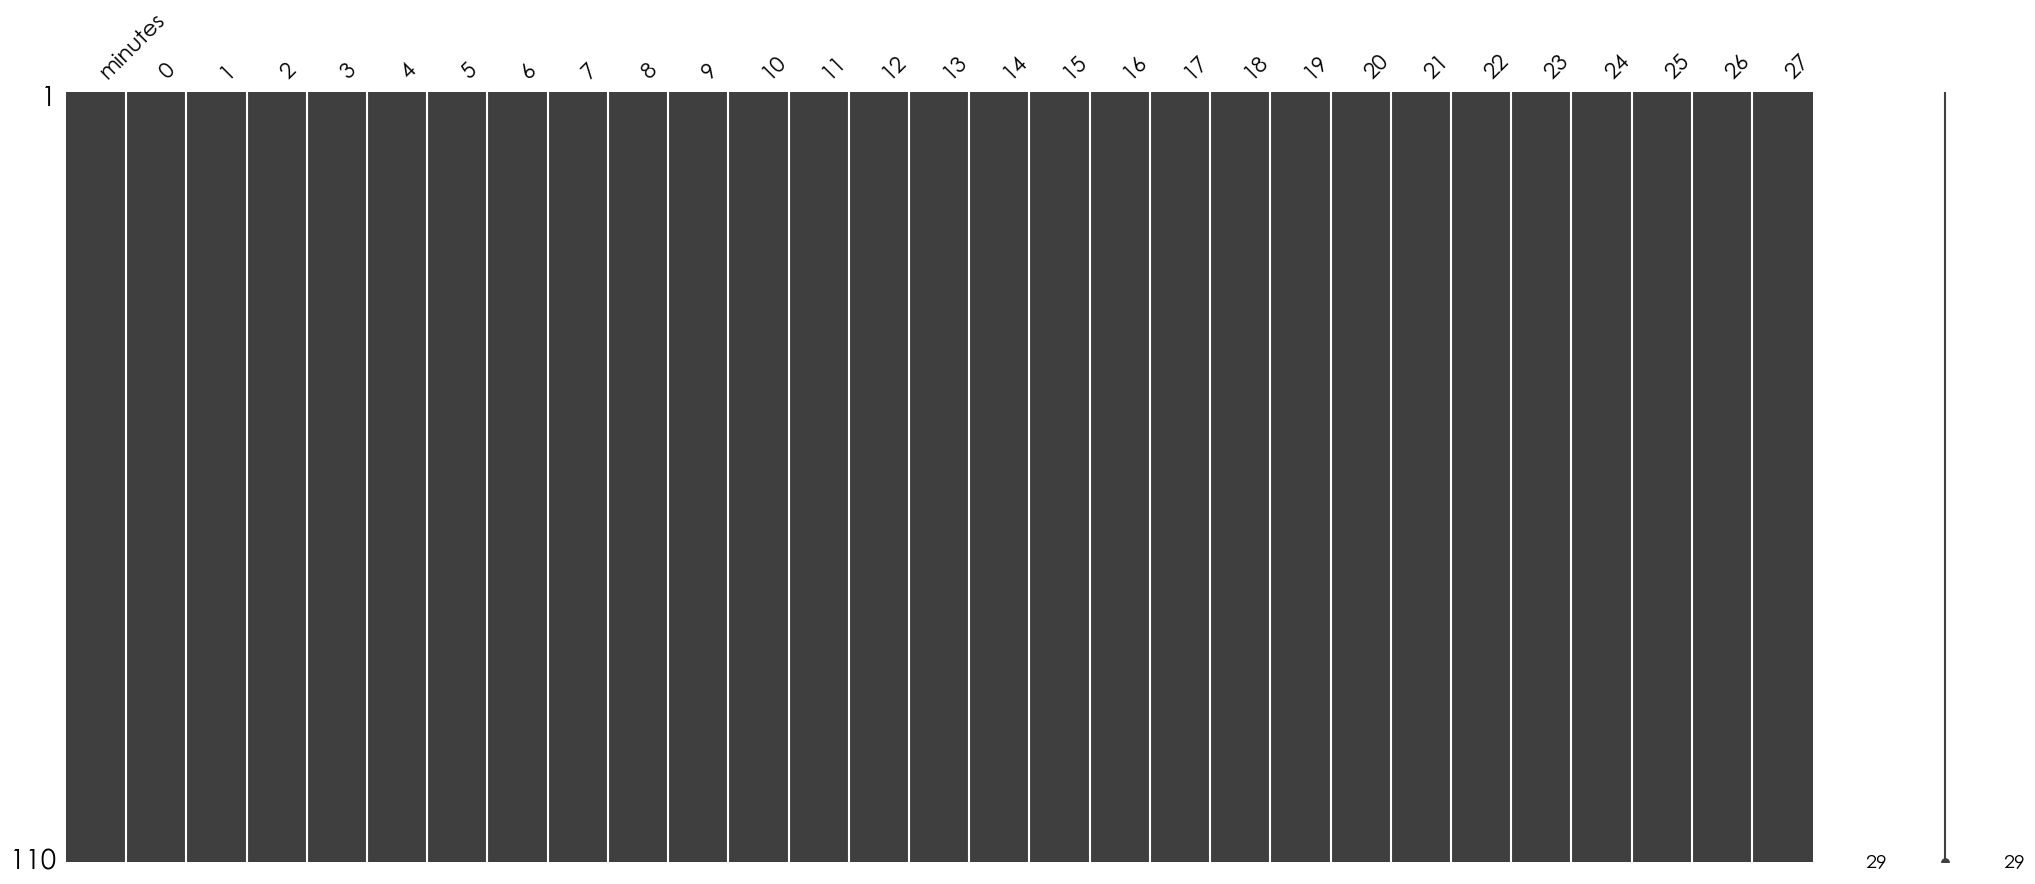

In [25]:
dic_temp = {}
for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_A ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_A ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({j:c})

for j, depth in enumerate(depth_layer):
    c = constituten(c = dic_prop['temp'], depth_s = dic_prop['depth'], depth_bd = depth, 
                lat_s = dic_prop['lat'], lat_bd = dic_prop['lat'][ilat_bd4_B ], 
                lon_s = dic_prop['lon'], lon_bd = dic_prop['lon'][ilon_bd4_B ], 
                idate_ini = ind_ini_fin[0], idate_fin= ind_ini_fin[1])
    dic_temp.update({n_capas + j:c})

df_temp = pd.DataFrame(dic_temp)
df_temp.insert(loc= 0, column = 'minutes', value = minutes)
# df_temp[17] = df_temp[18] - 1
# df_temp[1] = df_temp[2] - 1
# df_temp[0] = df_temp[1] - 1
msno.matrix(df_temp)

In [26]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'temp_oeste.bcc'
np.savetxt(path+'/'+name_file, df_temp.values, delimiter=' ', fmt = "%+15.7e")

In [37]:
fun_coords = lambda x: coord_wgs(df_bat_sai.iloc[x,0], df_bat_sai.iloc[x,1])
coords_bat = list(map(fun_coords, df_bat_sai.index))
df_bat_sai['lon'] = list(map(lambda x: coords_bat[x][0], df_bat_sai.index))
df_bat_sai['lat'] = list(map(lambda x: coords_bat[x][1], df_bat_sai.index))

In [39]:
df_bat_sai = df_bat_sai.replace([np.inf, -np.inf], np.nan)

In [40]:
df_bat_sai

,X,Y,lon,lat
0,418340.873,1386013.575,278.248364,12.536657
1,418340.873,1386113.575,278.248361,12.537562
2,418340.873,1386213.575,278.248359,12.538466
3,418340.873,1386313.575,278.248356,12.539370
4,418340.873,1386413.575,278.248353,12.540274
...,...,...,...,...
411,428040.873,1396413.575,278.337403,12.630933
412,428140.873,1396413.575,278.338323,12.630935
413,428240.873,1396413.575,278.339244,12.630938
414,428340.873,1396413.575,278.340165,12.630940


In [3]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
name_file = 'Hycom_april01_may31_2018_temp_sal.nc'
dic_val = read_hycom_data(path, name_file)
lat = dic_val['lat']
lon = dic_val['lon']

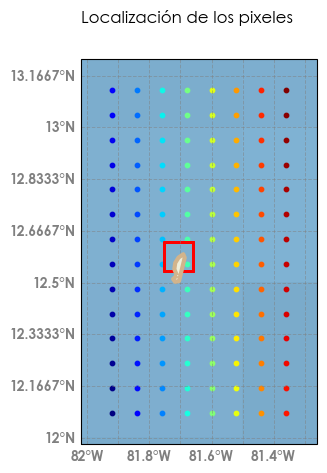

In [48]:
# lon = 360+Cords[:,0]
# lat = Cords[:,1]
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.stock_img()
ax1.add_feature(cf.LAND, zorder= 10)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
# ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
i = 0
for loni in (lon):
    for lati in (lat):
        ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
        i = i +1
# i = 0
# for loni, lati in zip (lon, lat):
#     ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(loni)+'-'+str(lati), color = colors_cm[i])
#     i=i+1

# ax1.scatter(360+lon_min, lat_min, marker = "*", s=10**2, color = 'red')
# ax1.scatter(360+lon_max, lat_max, marker = "*", s=10**2, color = 'red')
# ax1.scatter(360+lon_min, lat_max, marker = "*", s=10**2, color = 'red')
# ax1.scatter(360+lon_max, lat_min, marker = "*", s=10**2, color = 'red')

ax1.scatter(df_bat_sai['lon'], df_bat_sai['lat'],color = 'red', s=1)
ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')




#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')

# _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
#           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
fig.suptitle('Localización de los pixeles',size=12);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [5]:
dic_val.keys()

dict_keys(['time', 'lat', 'lon', 'depth', 'salt', 'temp'])

In [6]:
dic_val['depth']

array([   0.,    4.,    8.,   12.,   20.,   30.,   40.,   50.,   70.,
         90.,  125.,  200.,  300.,  400.,  600.,  800., 1000., 1500.,
       2500., 4000.])

In [7]:
dic_val['lat']

array([12.07999992, 12.15999985, 12.23999977, 12.31999969, 12.39999962,
       12.47999954, 12.56000042, 12.64000034, 12.72000027, 12.80000019,
       12.88000011, 12.96000004, 13.03999996, 13.11999989])

In [8]:
dic_val['lon']

array([278.08001709, 278.16003418, 278.23999023, 278.32000732,
       278.40002441, 278.47998047, 278.55999756, 278.64001465])